In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/dataset_from_json.csv')
df.head()

,words,sentence #,tag
0,CPT,0,Incoterms
1,LAHORE,0,Incoterms
2,AIRPORT,0,Incoterms
3,PAKISTAN,0,Incoterms
4,QTY,0,O


In [3]:
len(set(df.words)), len(df)

(9359, 60340)

In [4]:
words = list(set(df["words"].values))
words.append("ENDPAD")
n_words = len(words)
words[-1], n_words

('ENDPAD', 9360)

In [5]:
tags = list(set(df['tag'].values))
n_tags = len(tags)
tags, n_tags

(['Quantity',
  'UnitPriceAmount',
  'O',
  'GoodsDescription',
  'Incoterms',
  'GoodsOrigin',
  'Tolerance',
  'HSCode'],
 8)

# Analyse the tags

How many types of tags do you have?
How many of each tags do you have?
Which ones do you predict the best?

In [6]:
print(tags, n_tags)

df['tag'].groupby(df['tag']).size()

['Quantity', 'UnitPriceAmount', 'O', 'GoodsDescription', 'Incoterms', 'GoodsOrigin', 'Tolerance', 'HSCode'] 8


tag
GoodsDescription     9463
GoodsOrigin            46
HSCode                 31
Incoterms            7633
O                   30686
Quantity             4524
Tolerance             177
UnitPriceAmount      7780
Name: tag, dtype: int64

# Over-sample the minority classes.
In our case, I believe resampling the `GoodsOrigin`, `HSCode` and `Tolerance` until they reach 3.000 elements should be fine.

If we were to not have used text, I would have used better re-sampling methods, such as bootstrapping or StratifiedShuffleSplit, but because of the complexity of data I need to simple double the data. As such, I've had to artificially reproduce all the smallest values.

In [7]:
need_resampling = ['GoodsOrigin', 'HSCode', 'Tolerance']

grouping = df.groupby(df['sentence #'])
new_df = grouping.filter(lambda x: (x['tag'].apply(lambda tag: tag in need_resampling)).any())

In [8]:
new_df['sentence #'].groupby(new_df['sentence #']).count()

sentence #
28       40
54      114
187     115
208     181
230      53
       ... 
1542     34
1565     37
1566     58
1584     33
1603     35
Name: sentence #, Length: 79, dtype: int64

In [9]:
new_df.head()

,words,sentence #,tag
776,CFR,28,Incoterms
777,PAKISTAN,28,Incoterms
778,INTERNATIONAL,28,Incoterms
779,BULK,28,Incoterms
780,TERMINAL,28,Incoterms


In [10]:
for i in range(126):
    last_sentence_nr = df['sentence #'].max()
    new_sentences = set(new_df['sentence #'])
    nr_sentences_by_group = len(set(new_df['sentence #']))
    di = {}
    for val, i in enumerate(new_sentences):
        di[i] = val + last_sentence_nr + 2
    new_df['sentence #'] = new_df['sentence #'].map(di)
    df = df.append(new_df).reset_index()
    del df['index']

/tmp/ipykernel_601499/388070888.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_df).reset_index()
/tmp/ipykernel_601499/388070888.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_df).reset_index()
/tmp/ipykernel_601499/388070888.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_df).reset_index()
/tmp/ipykernel_601499/388070888.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_df).reset_index()
/tmp/ipykernel_601499/388070888.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [11]:
# doar pentru verificare
sorted = list(df['sentence #'].groupby(df['sentence #']).count())
sorted.sort(reverse=True)

In [12]:
import random
groups = [df for _, df in df.groupby('sentence #')]
random.shuffle(groups)
df = pd.concat(groups).reset_index(drop=True)

In [13]:
# last_sentence_nr = df.iloc[-1,1]
# new_sentences = set(new_df['sentence #'])
# nr_sentences_by_group = len(set(new_df['sentence #']))
# di = {}
# for val, i in enumerate(new_sentences):
#     di[i] = val + last_sentence_nr
# di

In [14]:
# last_sentence_nr = df.iloc[-1,1]
# last_sentence_nr += 1
# print('last sentence nr', last_sentence_nr)
# new_df['sentence #'] = new_df['sentence #'].apply(lambda x: x + last_sentence_nr)
# # df = df.append(new_df).reset_index()
# # del df['index']

In [15]:
# for i in range(126):
#     last_sentence_nr = df.iloc[-1,1]
#     print('last sentence nr', last_sentence_nr)
#     new_df['sentence #'] = new_df['sentence #'].apply(lambda x: x + last_sentence_nr)
#     df = df.append(new_df).reset_index()
#     del df['index']

In [13]:
df['tag'].groupby(df['tag']).size()

tag
GoodsDescription     69439
GoodsOrigin           5842
HSCode                3937
Incoterms            82729
O                   374414
Quantity             32370
Tolerance            22479
UnitPriceAmount      59818
Name: tag, dtype: int64

In [14]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 0
        self.data = df
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["words"].values.tolist(),
                                                     s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
getter = SentenceGetter(df)
getter.get_next()
print(getter.get_next())

[('SERVICES', 'GoodsDescription'), ('AND', 'GoodsDescription'), ('MAINTENANCE', 'GoodsDescription'), ('AS', 'O'), ('PER', 'O'), ("BENEFICIARY'S", 'O'), ('PROFORMA', 'O'), ('INVOICE', 'O'), ('NO.', 'O'), ('201912Q016H', 'O'), ('DATED', 'O'), ('05.12.2019', 'O')]


In [16]:
sentences = getter.sentences

In [17]:
print(sentences[0])
len(sentences)

[('CPT', 'Incoterms'), ('LAHORE', 'Incoterms'), ('AIRPORT', 'Incoterms'), ('PAKISTAN', 'Incoterms'), ('QTY', 'O'), ('1', 'Quantity'), ('PC', 'Quantity'), ('OF', 'O'), ('MULTI', 'GoodsDescription'), ('MODE', 'GoodsDescription'), ('READER/TRINOCULAR', 'GoodsDescription'), ('MICROSCOPE', 'GoodsDescription'), ('SYSTEM', 'GoodsDescription'), ('MODEL', 'O')]


11574

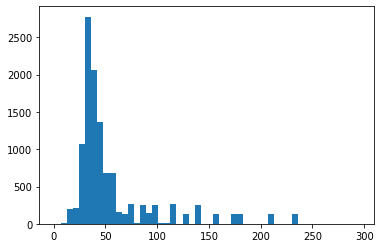

In [18]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [19]:
max_len = 300
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

import pickle
# Save the embeddings
with open("words_embeddings", "wb") as fp: 
    pickle.dump(word2idx, fp)

with open("tags_embeddings", "wb") as fp: 
    pickle.dump(tag2idx, fp)

In [20]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]

2022-08-29 12:15:13.013046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 12:15:13.013093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [21]:
# so we have the same length
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [22]:
print(X[1])

[4399  904 7153 5052 7772 7083 3447 1152 6278 3308  333 6682 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359 9359
 9359 

In [23]:
X.shape

(11574, 300)

In [24]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [25]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [26]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
print(y[1], tag2idx)

[3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2] {'Quantity': 0, 'UnitPriceAmount': 1, 'O': 2, 'GoodsDescription': 3, 'Incoterms': 4, 'GoodsOrigin': 5, 'Tolerance': 6, 'HSCode': 7}


In [29]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [31]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras import regularizers

In [32]:
regulaziers = regularizers.L1L2(l1=1e-5, l2=1e-5)

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)  # 50-dim embedding
model = Dropout(0.3)(model)
model = Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.1, kernel_regularizer=regulaziers))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

2022-08-29 12:16:05.123236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-29 12:16:05.123279: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-29 12:16:05.123304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (TudorMLTest1): /proc/driver/nvidia/version does not exist
2022-08-29 12:16:05.123876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
model = Model(input, out)

In [34]:
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", AUC(), Precision(), Recall()])

In [35]:
history = model.fit(X_train, np.array(y_train), batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
116/116 [==============================] - 174s 1s/step - loss: 0.2915 - accuracy: 0.9186 - auc: 0.9935 - precision: 0.9674 - recall: 0.8798 - val_loss: 0.1976 - val_accuracy: 0.9396 - val_auc: 0.9970 - val_precision: 0.9780 - val_recall: 0.9135
Epoch 2/10
116/116 [==============================] - 167s 1s/step - loss: 0.1209 - accuracy: 0.9646 - auc: 0.9989 - precision: 0.9844 - recall: 0.9502 - val_loss: 0.0641 - val_accuracy: 0.9862 - val_auc: 0.9997 - val_precision: 0.9939 - val_recall: 0.9795
Epoch 3/10
116/116 [==============================] - 174s 2s/step - loss: 0.0491 - accuracy: 0.9890 - auc: 0.9997 - precision: 0.9926 - recall: 0.9855 - val_loss: 0.0272 - val_accuracy: 0.9962 - val_auc: 1.0000 - val_precision: 0.9974 - val_recall: 0.9951
Epoch 4/10
116/116 [==============================] - 170s 1s/step - loss: 0.0295 - accuracy: 0.9945 - auc: 0.9998 - precision: 0.9955 - recall: 0.9936 - val_loss: 0.0149 - val_accuracy: 0.9990 - val_auc: 1.0000 - val_precision: 

In [36]:
hist = pd.DataFrame(history.history)
hist

,loss,accuracy,auc,precision,recall,val_loss,val_accuracy,val_auc,val_precision,val_recall
0,0.291493,0.918648,0.993543,0.967409,0.879829,0.197618,0.939584,0.997042,0.978031,0.913458
1,0.120882,0.964650,0.998900,0.984375,0.950228,0.064125,0.986247,0.999712,0.993897,0.979514
2,0.049077,0.988966,0.999728,0.992623,0.985548,0.027210,0.996177,0.999967,0.997355,0.995081
3,0.029470,0.994546,0.999843,0.995505,0.993577,0.014912,0.998985,0.999999,0.999111,0.998818
4,0.021467,0.996334,0.999886,0.996805,0.995871,0.010749,0.999703,1.000000,0.999746,0.999660
5,0.017185,0.997082,0.999901,0.997385,0.996806,0.009215,0.999541,1.000000,0.999582,0.999498
6,0.014443,0.997442,0.999921,0.997709,0.997232,0.006108,1.000000,1.000000,1.000000,1.000000
7,0.012806,0.997673,0.999921,0.997886,0.997474,0.005217,1.000000,1.000000,1.000000,1.000000
8,0.011063,0.997977,0.999936,0.998179,0.997808,0.004756,0.999960,1.000000,0.999960,0.999960
9,0.010047,0.998078,0.999942,0.998249,0.997907,0.004406,0.999917,1.000000,0.999917,0.999917


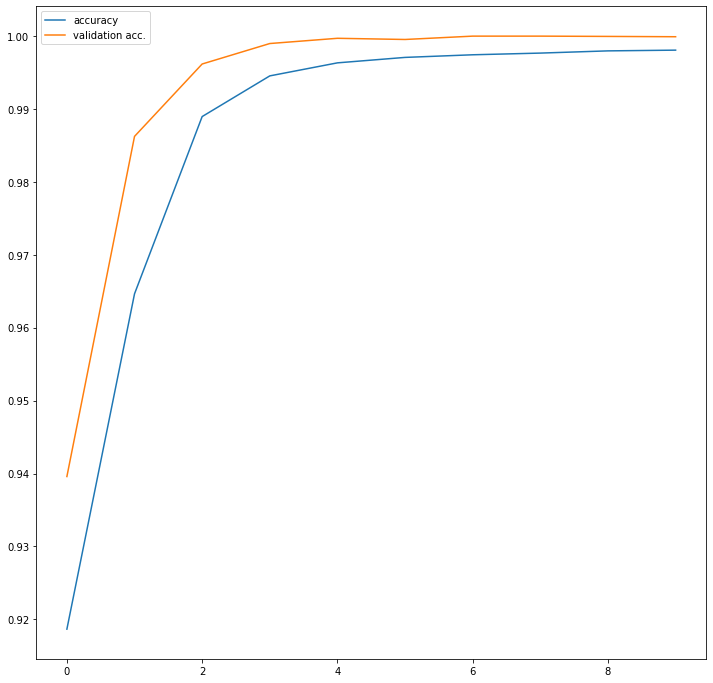

In [37]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label='accuracy')
plt.plot(hist["val_accuracy"], label='validation acc.')
plt.legend()
plt.show()

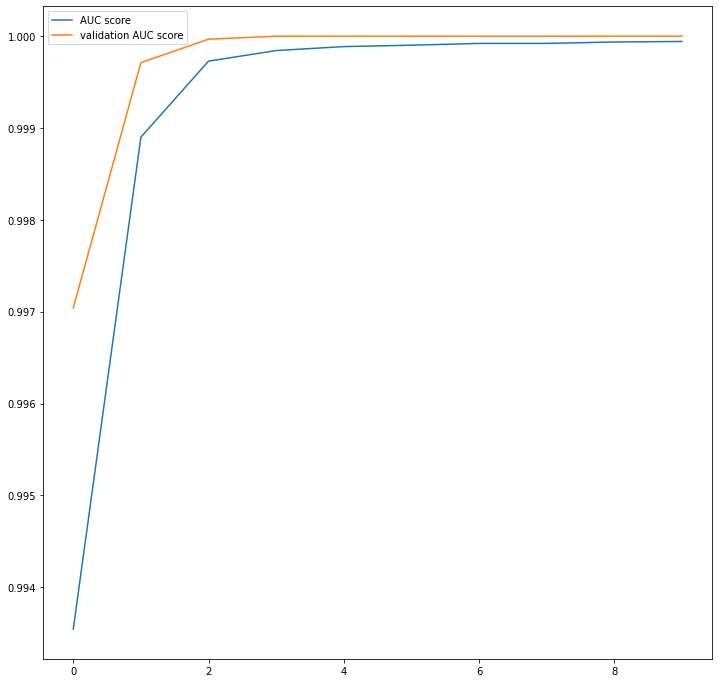

In [38]:
plt.figure(figsize=(12,12))
plt.plot(hist["auc"], label="AUC score")
plt.plot(hist["val_auc"], label="validation AUC score")
plt.legend()
plt.show()

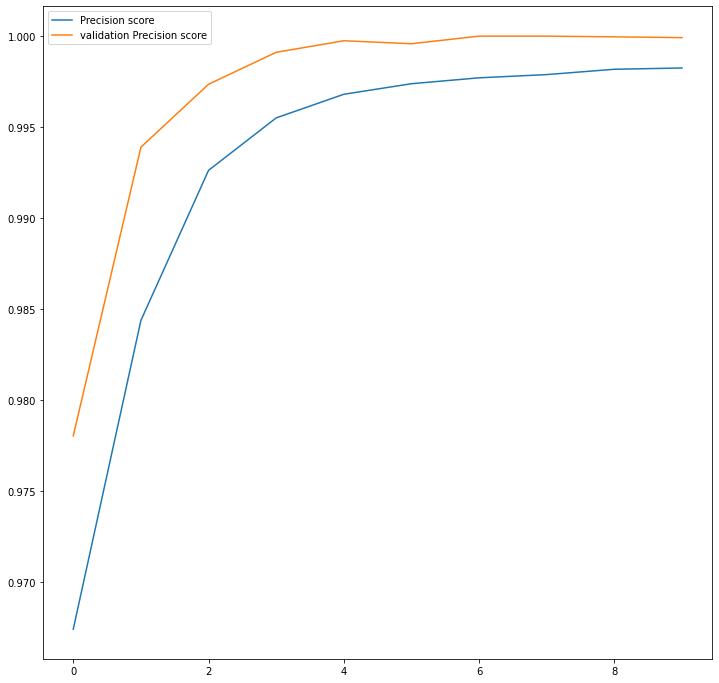

In [39]:
plt.figure(figsize=(12,12))
plt.plot(hist["precision"], label="Precision score")
plt.plot(hist["val_precision"], label="validation Precision score")
plt.legend()
plt.show()

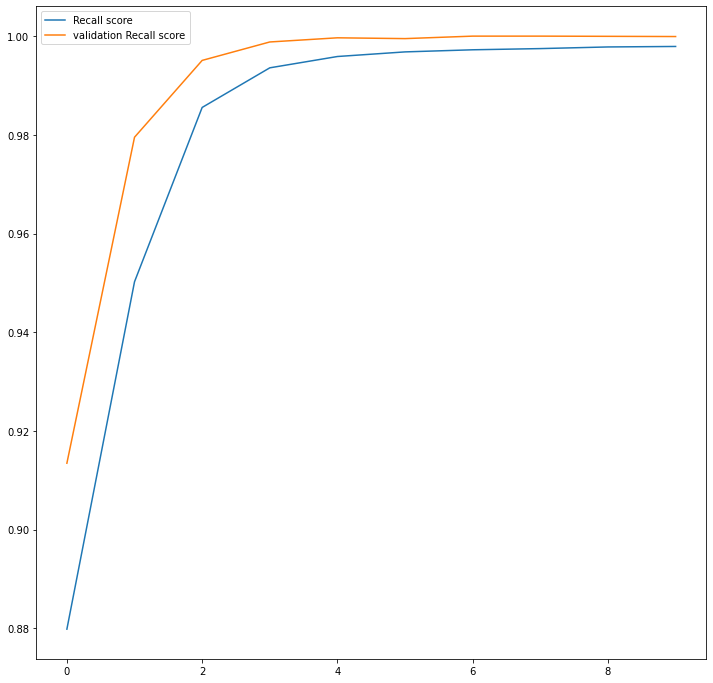

In [40]:
plt.figure(figsize=(12,12))
plt.plot(hist["recall"], label="Recall score")
plt.plot(hist["val_recall"], label="validation Recall score")
plt.legend()
plt.show()

In [41]:
model.save('../output/NER_model_updated.h5')